# 0. Libs & Initialization

In [1]:
!pip install pandasql -q
!pip install catboost -q
!pip install shap -q
!pip install openpyxl -q

In [2]:
import pickle
import json
import calendar
import gc
import random
from datetime import date, timedelta, datetime
import openpyxl

from tqdm.auto import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

import seaborn as sns
sns.set_palette('muted') # for the sns palette
sns.set_color_codes('muted')
sns.set_style('white') # grid

import matplotlib.pyplot as plt
# pd.options.plotting.backend = "plotly"

import warnings
warnings.filterwarnings('ignore')

import scipy.stats
from statsmodels.graphics.mosaicplot import mosaic
from pandasql import sqldf

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
from sklearn.metrics import precision_score, average_precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_recall_curve, RocCurveDisplay 
from sklearn.metrics import roc_curve, auc, f1_score

import shap

from catboost import CatBoostClassifier
from catboost import Pool

In [4]:
home_repo = '/home/jovyan'
project_repo = f'{home_repo}/__RAYDTT'

%cd {project_repo}
%pwd

/home/jovyan/__RAYDTT


'/home/jovyan/__RAYDTT'

In [5]:
SEED = 42
model_name = 'CatBoostClassifier'
trials_path = '/pickles/{}_optuna_trials.pickle'.format(model_name)

In [6]:
np.random.seed(SEED)
random.seed(SEED)

In [7]:
def plot_roc_curve(y_true, y_pred_proba):

    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Plot the ROC curve
    plt.figure(figsize=(17, 10))
    plt.plot(fpr, tpr, color=color[0] , lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color=color[1], lw=2, linestyle='--') # ['#74197f','#14b956']
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return roc_auc

In [36]:
def get_reports(y_pred, y_true, perc=[0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]):

    y_pred = pd.Series(y_pred)
    y_true = pd.Series(y_true)
    print('ROC AUC: %.3f' % roc_auc_score(y_true, y_pred))

    coef = y_true.sum() / len(y_true)

    report = pd.DataFrame(columns=[], index=['LIFT', 'PRECISION', 'RECALL', 'COUNT'])   

    for p in perc:

        thr = y_pred.quantile(1-p)

        report['top {}%'.format(int(p*100))] = pd.Series([

            np.round(precision_score(y_true, np.round(y_pred-thr+0.5)) / coef, 3),

            np.round(precision_score(y_true, np.round(y_pred-thr+0.5)), 3),

            np.round(recall_score(y_true, np.round(y_pred-thr+0.5)), 3),

            str(np.round(y_pred-thr+0.5).sum())[:-2]

        ], index=report.index)
    
    return report

In [27]:
def get_reports_pd(y_pred, y_true, perc=[0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]):
    
    metrics_list = []
    y_pred = pd.Series(y_pred)
    y_true = pd.Series(y_true)

    coef = y_true.sum() / len(y_true)

    #report = pd.DataFrame(columns=[], index=['LIFT', 'PRECISION', 'RECALL', 'COUNT'])   

    for p in perc:
        
        metrics_dict = {}

        thr = y_pred.quantile(1-p)
        
        precision = np.round(precision_score(y_true, np.round(y_pred-thr+0.5)), 3)
        precision_lift = np.round(precision_score(y_true, np.round(y_pred-thr+0.5)) / coef, 3)
        
        recall = np.round(recall_score(y_true, np.round(y_pred-thr+0.5)), 3)
        
        f1 = np.round(f1_score(y_true, np.round(y_pred-thr+0.5)), 3)
        #f1_lift = np.round(f1_score(y_true, np.round(y_pred-thr+0.5)) / coef, 3)
        
        count = int(np.round(y_pred-thr+0.5).sum())
        
        metrics_dict['MODEL'] = model_name
        metrics_dict['TOP'] = f'{str(int(p*100))}%'
        metrics_dict['COUNT'] = count
        metrics_dict['F1@TOP'] = f1
        metrics_dict['RECALL@TOP'] = recall
        metrics_dict['PRECISION@TOP'] = precision
        metrics_dict['LIFT@TOP'] = precision_lift
        #metrics_dict['F1_LIFT@TOP'] = f1_lift
        
        metrics_list.append(metrics_dict)
        
    result_df = pd.DataFrame(metrics_list)
    
    return result_df

In [9]:
color_0 = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
color_1 = ['#74197f','#14b956']
color = ['#3288bd', '#99d594']
color = color + color_0 + color_1

# `CatBoostClassifier()`

In [10]:
!cd cb_best; ls -a

.	     cb_best_params.json    cb_best_valid.parquet  valid.csv
..	     cb_best_test.parquet   .ipynb_checkpoints
10_perc.csv  cb_best_train.parquet  test.csv


In [11]:
train = pd.read_parquet('cb_best/cb_best_train.parquet')
valid = pd.read_parquet('cb_best/cb_best_valid.parquet')
test = pd.read_parquet('cb_best/cb_best_test.parquet')
train.shape, valid.shape, test.shape

((53825, 273), (10187, 273), (75127, 273))

In [12]:
with open('cb_best/cb_best_params.json') as json_file:
    params = json.load(json_file)

In [13]:
valid.sample(frac=0.1).to_csv('cb_best/10_perc.csv')

## `CatBoost()`

In [14]:
X_train, y_train = train.drop(columns=['target']), train.target
X_valid, y_valid = valid.drop(columns=['target']), valid.target
X_test, y_test = test.drop(columns=['target']), test.target
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((53825, 272), (53825,), (10187, 272), (10187,), (75127, 272), (75127,))

In [15]:
catboost = CatBoostClassifier(**params)

In [16]:
%%time
catboost.fit(X_train, y_train)

CPU times: user 27.3 s, sys: 623 ms, total: 27.9 s
Wall time: 2.91 s


In [17]:
%%time
catboost_pred_train = catboost.predict(X_train)
catboost_proba_train = catboost.predict_proba(X_train)[:, 1]

catboost_pred_valid = catboost.predict(X_valid)
catboost_proba_valid = catboost.predict_proba(X_valid)[:, 1] 

catboost_pred_test = catboost.predict(X_test)
catboost_proba_test = catboost.predict_proba(X_test)[:, 1]

CPU times: user 2.45 s, sys: 139 ms, total: 2.59 s
Wall time: 1.25 s


In [18]:
catboost_pred_train.sum(), y_train.sum(),\
catboost_pred_valid.sum(), y_valid.sum(),\
catboost_pred_test.sum(), y_test.sum()

(70, 4988, 837, 955, 5323, 578)

In [19]:
pickle.dump(catboost, open(r'pickles/catboost_model_final.pickle.dat','wb')) 

In [20]:
!cd pickles; ls -a

.				 catboost_model_upd.pickle.dat
..				 svarygin_2105_catboost_model.pickle.dat
catboost_model_final.pickle.dat  xgboost_model.pickle.dat
catboost_model.pickle.dat


## Train Metrics

In [19]:
accuracy = accuracy_score(y_train, catboost_pred_train)
balanced_accuracy = balanced_accuracy_score(y_train, catboost_pred_train)
average_precision = average_precision_score(y_train, catboost_proba_train)
recall = recall_score(y_train, catboost_pred_train)
precision = precision_score(y_train, catboost_pred_train)
roc_auc = roc_auc_score(y_train, catboost_proba_train)
f1 = f1_score(y_train, catboost_pred_train)

precision_points, recall_points, _ = precision_recall_curve(y_train, catboost_proba_train) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.907
Balanced accuracy: 0.503
Average precision: 0.246
Recall: 0.007
Precision: 0.486
F1: 0.013
ROC AUC: 0.731
PRC AUC: 0.246


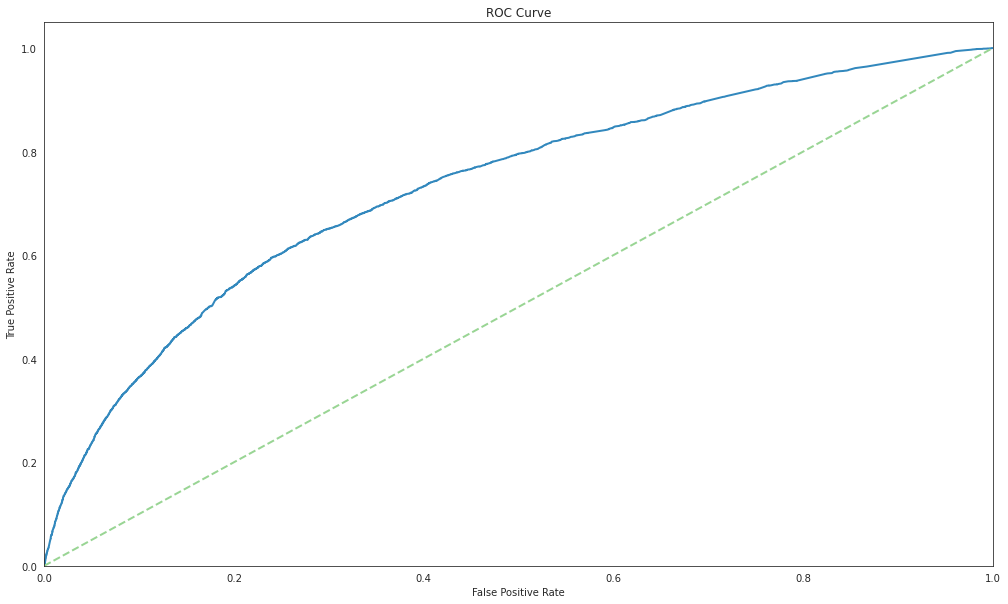

0.7305174226608755

In [22]:
plot_roc_curve(y_train, catboost_proba_train)

In [23]:
get_reports(catboost_proba_train, y_train)

ROC AUC: 0.731


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,4.845,4.330,3.760,3.181,2.738,2.472,2.072,1.768,1.559,1.400,1.270,1.170,1.101,1.000
PRECISION,0.449,0.401,0.348,0.295,0.254,0.229,0.192,0.164,0.144,0.130,0.118,0.108,0.102,0.093
RECALL,0.049,0.130,0.188,0.318,0.411,0.494,0.621,0.706,0.779,0.836,0.889,0.936,0.964,1.000
COUNT,539.000,1615.000,2692.000,5383.000,8074.000,10765.000,16148.000,21510.000,26912.000,32160.000,37657.000,43051.000,47158.000,53823.000


## Valid Metrics

In [22]:
accuracy = accuracy_score(y_valid, catboost_pred_valid)
balanced_accuracy = balanced_accuracy_score(y_valid, catboost_pred_valid)
average_precision = average_precision_score(y_valid, catboost_proba_valid)
recall = recall_score(y_valid, catboost_pred_valid)
precision = precision_score(y_valid, catboost_pred_valid)
roc_auc = roc_auc_score(y_valid, catboost_proba_valid)
f1 = f1_score(y_valid, catboost_pred_valid)

precision_points, recall_points, _ = precision_recall_curve(y_valid, catboost_proba_valid) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.868
Balanced accuracy: 0.584
Average precision: 0.208
Recall: 0.235
Precision: 0.268
F1: 0.25
ROC AUC: 0.689
PRC AUC: 0.207


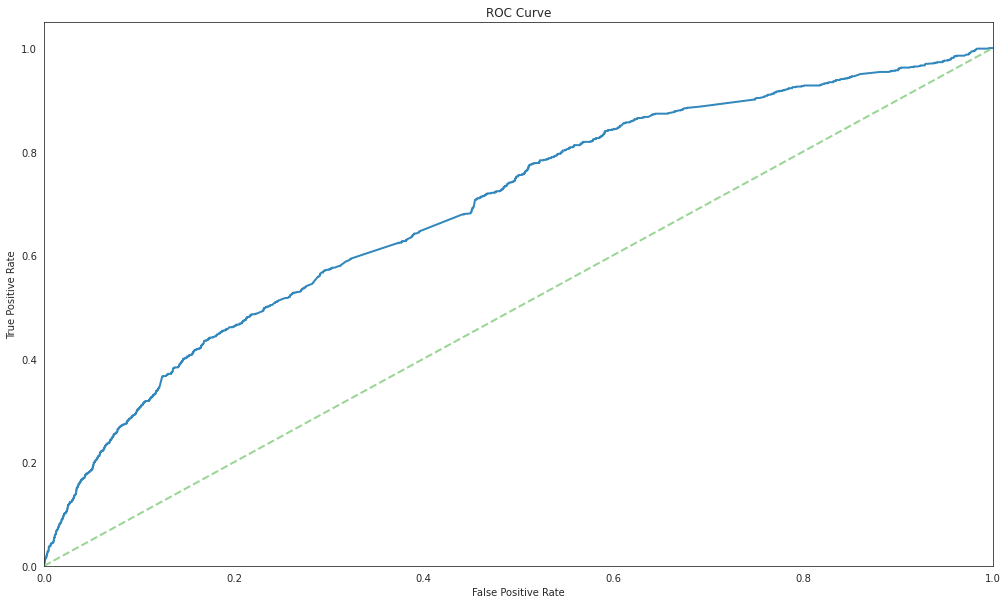

0.6894384544538913

In [23]:
plot_roc_curve(y_valid, catboost_proba_valid)

In [24]:
get_reports(catboost_proba_valid, y_valid)

ROC AUC: 0.689


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,4.079,3.416,3.263,2.714,2.443,2.204,1.794,1.563,1.447,1.367,1.267,1.153,1.062,1.000
PRECISION,0.382,0.320,0.306,0.254,0.229,0.207,0.168,0.147,0.136,0.128,0.119,0.108,0.100,0.094
RECALL,0.041,0.103,0.163,0.271,0.366,0.441,0.538,0.625,0.724,0.820,0.885,0.923,0.956,1.000
COUNT,102.000,306.000,510.000,1018.000,1528.000,2038.000,3056.000,4075.000,5093.000,6109.000,7116.000,8149.000,9168.000,10186.000


## Test Metrics

In [24]:
accuracy = accuracy_score(y_test, catboost_pred_test)
balanced_accuracy = balanced_accuracy_score(y_test, catboost_pred_test)
average_precision = average_precision_score(y_test, catboost_proba_test)
recall = recall_score(y_test, catboost_pred_test)
precision = precision_score(y_test, catboost_pred_test)
roc_auc = roc_auc_score(y_test, catboost_proba_test)
f1 = f1_score(y_test, catboost_pred_test)

precision_points, recall_points, _ = precision_recall_curve(y_test, catboost_proba_test) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.926
Balanced accuracy: 0.619
Average precision: 0.027
Recall: 0.308
Precision: 0.033
F1: 0.06
ROC AUC: 0.728
PRC AUC: 0.027


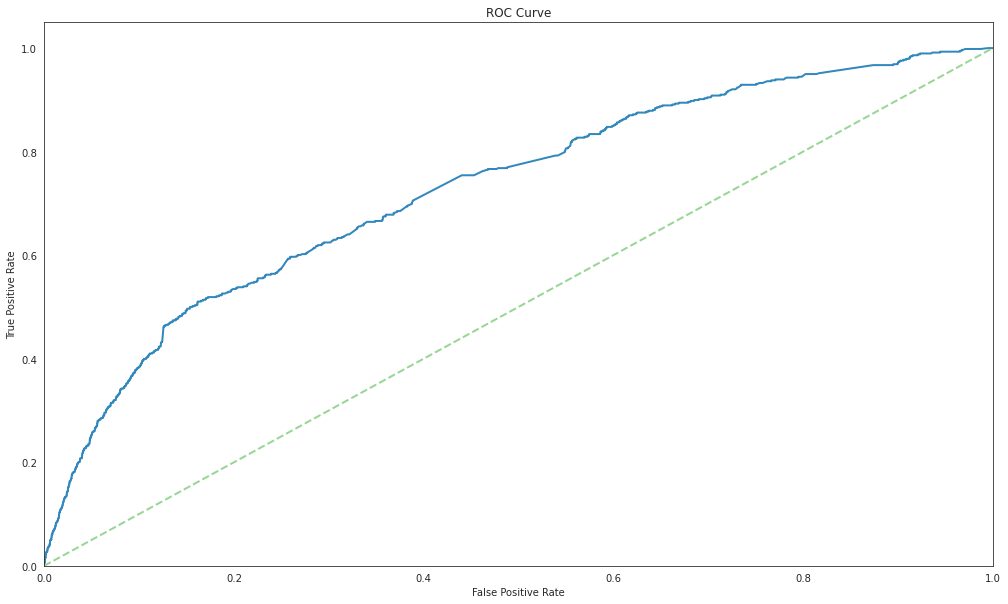

0.7281926482853456

In [25]:
plot_roc_curve(y_test, catboost_proba_test)

In [28]:
get_reports_pd(catboost_proba_test, y_test)

,MODEL,TOP,COUNT,F1@TOP,RECALL@TOP,PRECISION@TOP,LIFT@TOP
0,CatBoostClassifier,1%,752,0.057,0.066,0.051,6.568
1,CatBoostClassifier,3%,2254,0.071,0.173,0.044,5.767
2,CatBoostClassifier,5%,3757,0.066,0.246,0.038,4.913
3,CatBoostClassifier,10%,7513,0.054,0.381,0.029,3.806
4,CatBoostClassifier,15%,11269,0.048,0.488,0.025,3.253
5,CatBoostClassifier,20%,15008,0.040,0.533,0.021,2.667
6,CatBoostClassifier,30%,22533,0.031,0.625,0.016,2.082
7,CatBoostClassifier,40%,29418,0.027,0.706,0.014,1.803
8,CatBoostClassifier,50%,36858,0.024,0.770,0.012,1.569
9,CatBoostClassifier,60%,45076,0.021,0.848,0.011,1.413


In [37]:
get_reports(catboost_proba_test, y_test)

ROC AUC: 0.728


,top 1%,top 3%,top 5%,top 10%,top 15%,top 20%,top 30%,top 40%,top 50%,top 60%,top 70%,top 80%,top 90%,top 100%
LIFT,6.568,5.767,4.913,3.806,3.253,2.667,2.082,1.803,1.569,1.413,1.29,1.181,1.077,1.0
PRECISION,0.051,0.044,0.038,0.029,0.025,0.021,0.016,0.014,0.012,0.011,0.01,0.009,0.008,0.008
RECALL,0.066,0.173,0.246,0.381,0.488,0.533,0.625,0.706,0.77,0.848,0.903,0.945,0.969,1.0
COUNT,752,2254,3757,7513,11269,15008,22533,29418,36858,45076,52577,60075,67593,75126


In [39]:
X_test.columns.to_list()

['amplitude_id',
 'target_month',
 'explain_errors_sum_20',
 'explain_errors_avg_20',
 'explain_errors_min_20',
 'explain_errors_max_20',
 'explain_errors_std_20',
 'favorites_count_sum_20',
 'favorites_count_avg_20',
 'favorites_count_min_20',
 'favorites_count_max_20',
 'favorites_count_std_20',
 'hazard_progress_sum_20',
 'hazard_progress_avg_20',
 'hazard_progress_min_20',
 'hazard_progress_max_20',
 'hazard_progress_std_20',
 'hazard_solved_sum_20',
 'hazard_solved_avg_20',
 'hazard_solved_min_20',
 'hazard_solved_max_20',
 'hazard_solved_std_20',
 'percent_solved_sum_20',
 'percent_solved_avg_20',
 'percent_solved_min_20',
 'percent_solved_max_20',
 'percent_solved_std_20',
 'cohort_day_sum_20',
 'cohort_day_avg_20',
 'cohort_day_min_20',
 'cohort_day_max_20',
 'cohort_day_std_20',
 'cohort_week_sum_20',
 'cohort_week_avg_20',
 'cohort_week_min_20',
 'cohort_week_max_20',
 'cohort_week_std_20',
 'cohort_month_sum_20',
 'cohort_month_avg_20',
 'cohort_month_min_20',
 'cohort_month

In [40]:
X_test.shape

(75127, 272)

In [41]:
X_train.target_month

585651    2023-07-01
99837     2023-01-01
15373     2023-02-01
693381    2022-06-01
248029    2023-03-01
             ...    
427547    2023-01-01
486538    2023-06-01
509902    2022-06-01
203069    2023-07-01
141998    2022-08-01
Name: target_month, Length: 53825, dtype: object

In [43]:
X_valid.target_month

138254    2023-08-01
34097     2023-08-01
351322    2023-08-01
309560    2023-08-01
266911    2023-08-01
             ...    
398148    2023-08-01
448375    2023-08-01
359434    2023-08-01
127810    2023-08-01
404704    2023-08-01
Name: target_month, Length: 10187, dtype: object

In [42]:
X_test.target_month

27        2023-09-01
35        2023-09-01
40        2023-09-01
103       2023-09-01
121       2023-09-01
             ...    
766151    2023-09-01
766204    2023-09-01
766293    2023-09-01
766331    2023-09-01
768605    2023-09-01
Name: target_month, Length: 75127, dtype: object

## matrix

In [68]:
conf_matrix = confusion_matrix(y_test, catboost_pred_test)
conf_matrix

array([[69404,  5145],
       [  400,   178]])

Confusion Matrix (Tabular):
          Predicted 0  Predicted 1
Actual 0        69404         5145
Actual 1          400          178


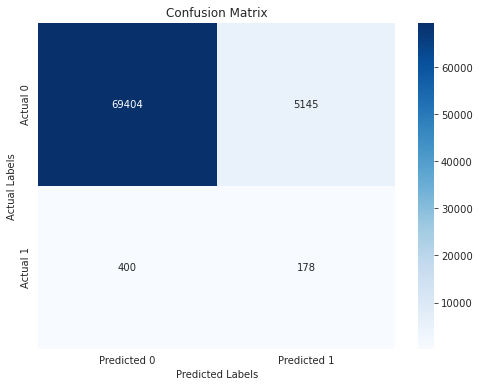

In [69]:
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])
print("Confusion Matrix (Tabular):")
print(conf_matrix_df)

# Using seaborn and matplotlib for graphical visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
X_test.shape

(75127, 272)

## SHAP

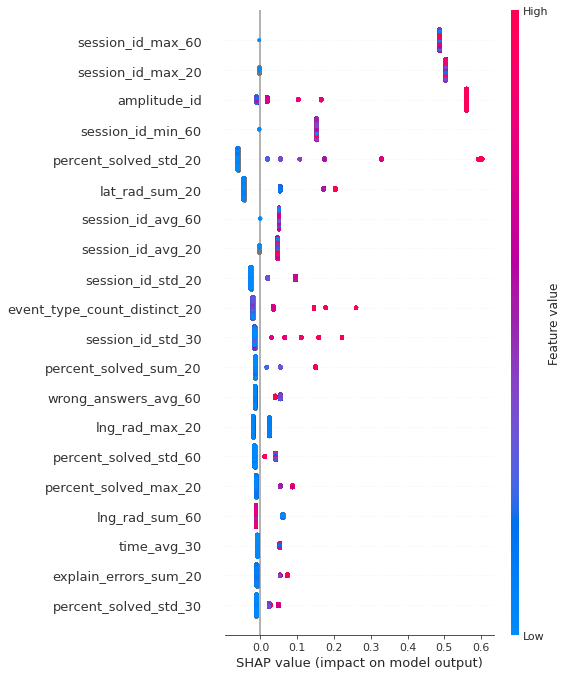

CPU times: user 31.1 s, sys: 5.69 s, total: 36.8 s
Wall time: 13.2 s


In [26]:
%%time
explainer = shap.TreeExplainer(catboost)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type='dot') # use this easier

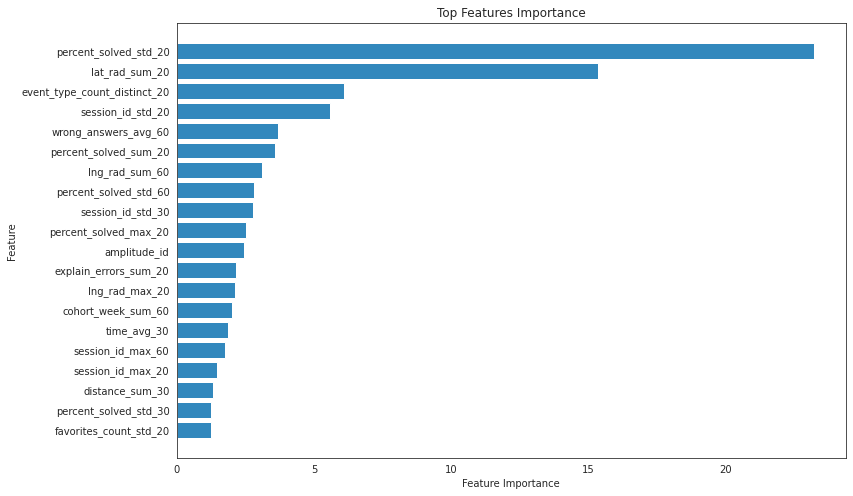

CPU times: user 304 ms, sys: 228 ms, total: 532 ms
Wall time: 258 ms


In [28]:
%%time
feature_importance = catboost.get_feature_importance()
feature_names = X_train.columns
sorted_feature_importance = sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)

top_40_features = [feature for feature, importance in sorted_feature_importance[:20]]
top_40_importance = [importance for feature, importance in sorted_feature_importance[:20]]

plt.figure(figsize=(12, 8))
plt.barh(top_40_features, top_40_importance, color=color[0]) # '#74197f','#14b956'
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top Features Importance')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

-----------------

In [91]:
results_df = pd.DataFrame({
    'Real Label': y_test,
    'Predicted Probability': catboost_proba_test,
    'Predicted Label': catboost_pred_test,
})


results_df = results_df.sort_values(by = ['Predicted Probability'], ascending = False)
model_200 = results_df.head(2000)

In [92]:
y_test_model, catboost_pred_test_model, catboost_proba_test_model = model_200['Real Label'], model_200['Predicted Label'], model_200['Predicted Probability']
accuracy = accuracy_score(y_test_model, catboost_pred_test_model)
balanced_accuracy = balanced_accuracy_score(y_test_model, catboost_pred_test_model)
average_precision = average_precision_score(y_test_model, catboost_proba_test_model)
recall = recall_score(y_test_model, catboost_pred_test_model)
precision = precision_score(y_test_model, catboost_pred_test_model)
roc_auc = roc_auc_score(y_test_model, catboost_proba_test_model)
f1 = f1_score(y_test_model, catboost_pred_test_model)

precision_points, recall_points, _ = precision_recall_curve(y_test_model, catboost_proba_test_model) 
prc_auc = auc(recall_points, precision_points)

print('Accuracy:', np.round(accuracy, 3))
print('Balanced accuracy:', np.round(balanced_accuracy, 3))
print('Average precision:', np.round(average_precision, 3))
print('Recall:', np.round(recall, 3))
print('Precision:', np.round(precision, 3))
print('F1:', np.round(f1, 3))
print('ROC AUC:', np.round(roc_auc, 3))
print('PRC AUC:', np.round(prc_auc, 3))

Accuracy: 0.044
Balanced accuracy: 0.5
Average precision: 0.059
Recall: 1.0
Precision: 0.044
F1: 0.084
ROC AUC: 0.537
PRC AUC: 0.056


-------

In [94]:
results_df = pd.DataFrame({
    'Real Label': y_test,
    'Predicted Probability': catboost_proba_test,
    'Predicted Label': catboost_pred_test,
})

In [95]:
metrics_list = []
for i in tqdm(range(1000)):
    
    random_200 = results_df.sample(2000) #SEED = np.random)
    metrics_dict = {}

    y_test_random, catboost_pred_test_random, catboost_proba_test_random = random_200['Real Label'], random_200['Predicted Label'], random_200['Predicted Probability']
#     accuracy = accuracy_score(y_test_random, catboost_pred_test_random)
#     balanced_accuracy = balanced_accuracy_score(y_test_random, catboost_pred_test_random)
    average_precision = average_precision_score(y_test_random, catboost_proba_test_random)
    recall = recall_score(y_test_random, catboost_pred_test_random)
    precision = precision_score(y_test_random, catboost_pred_test_random)
#     roc_auc = roc_auc_score(y_test_random, catboost_proba_test_random)
    f1 = f1_score(y_test_random, catboost_pred_test_random)

    precision_points, recall_points, _ = precision_recall_curve(y_test_random, catboost_proba_test_random) 
    prc_auc = auc(recall_points, precision_points)
    
    metrics_dict['average_precision'] = average_precision
    metrics_dict['recall'] = recall
    metrics_dict['precision'] = precision
    metrics_dict['f1'] = f1
    
    metrics_list.append(metrics_dict)
    
#     print('Accuracy:', np.round(accuracy, 3))
#     print('Balanced accuracy:', np.round(balanced_accuracy, 3))
#     print('Average precision:', np.round(average_precision, 3))
#     print('Recall:', np.round(recall, 3))
#     print('Precision:', np.round(precision, 3))
#     print('F1:', np.round(f1, 3))
#     print('ROC AUC:', np.round(roc_auc, 3))
#     print('PRC AUC:', np.round(prc_auc, 3))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [104]:
metrics_pd = pd.DataFrame(metrics_list)

metrics_pd['average_precision_model'] = 0.059
metrics_pd['recall_model'] = 1
metrics_pd['precision_model'] = 0.044
metrics_pd['f1_model'] = 0.084

metrics_pd['precision_check'] = metrics_pd['precision'] > metrics_pd['precision_model']
metrics_pd['recall_check'] = metrics_pd['recall'] > metrics_pd['recall_model']
metrics_pd['f1_check'] = metrics_pd['f1'] > metrics_pd['f1_model']
metrics_pd['average_precision_check'] = metrics_pd['average_precision'] > metrics_pd['average_precision_model']

print('precision better in random:', metrics_pd['precision_check'].mean())
print('recall better in random:', metrics_pd['recall_check'].mean())
print('f1 better in random:', metrics_pd['f1_check'].mean())
print('average precision better in random:', metrics_pd['average_precision_check'].mean())

precision better in random: 0.215
recall better in random: 0.0
f1 better in random: 0.166
average precision better in random: 0.218


In [105]:
metrics_pd = pd.DataFrame(metrics_list)

metrics_pd['average_precision_model'] = 0.059
metrics_pd['recall_model'] = 1
metrics_pd['precision_model'] = 0.044
metrics_pd['f1_model'] = 0.084

metrics_pd['precision_check'] = metrics_pd['precision'] > metrics_pd['precision_model']
metrics_pd['recall_check'] = metrics_pd['recall'] > metrics_pd['recall_model']
metrics_pd['f1_check'] = metrics_pd['f1'] > metrics_pd['f1_model']
metrics_pd['average_precision_check'] = metrics_pd['average_precision'] > metrics_pd['average_precision_model']

print('precision better in random:', metrics_pd['precision_check'].mean())
print('recall better in random:', metrics_pd['recall_check'].mean())
print('f1 better in random:', metrics_pd['f1_check'].mean())
print('average precision better in random:', metrics_pd['average_precision_check'].mean())

precision better in random: 0.215
recall better in random: 0.0
f1 better in random: 0.166
average precision better in random: 0.218


In [107]:
demo = ['average_precision', 'average_precision_model',
          'recall', 'recall_model',
          'precision', 'precision_model',
          'f1', 'f1_model']
metrics_pd[metrics_pd['precision_check'] == True][demo]

,average_precision,average_precision_model,recall,recall_model,precision,precision_model,f1,f1_model
1,0.040360,0.059,0.571429,1,0.053333,0.044,0.097561,0.084
7,0.053272,0.059,0.333333,1,0.050955,0.044,0.088398,0.084
10,0.034924,0.059,0.400000,1,0.056738,0.044,0.099379,0.084
12,0.039738,0.059,0.315789,1,0.044118,0.044,0.077419,0.084
17,0.038461,0.059,0.437500,1,0.045455,0.044,0.082353,0.084
...,...,...,...,...,...,...,...,...
976,0.048009,0.059,0.315789,1,0.044776,0.044,0.078431,0.084
977,0.065735,0.059,0.571429,1,0.056738,0.044,0.103226,0.084
980,0.051920,0.059,0.500000,1,0.047945,0.044,0.087500,0.084
991,0.136835,0.059,0.368421,1,0.052632,0.044,0.092105,0.084


--------